In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this assignment, you will work with RNNs for text classification. Get familiar with the link below:

https://www.tensorflow.org/tutorials/text/text_classification_rnn (Links to an external site.)

Can you train and test what happens with different settings?

Embedding sizes: Three different sizes -**Used (64,84,96)**

Vocabulary size. - **Used (1000,2000)**

Size of hidden states in the LSTM. **-Used(64,84,96,32)**

GRU in place of LSTM. Which is faster to train? **(Used) LSTM**

Two different optimizers in place of Adam. **Used (Adagrad, RMSprop)**




In [ ]:
import tarfile
import os
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
punctuations= string.punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopword_list = stopwords.words("english")
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,f1_score,precision_recall_fscore_support,log_loss
from sklearn.linear_model import Lasso, SGDClassifier,LogisticRegression as LR
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.svm import SVC
import seaborn as sns
import pylab as pl
import tensorflow as tf
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteON2YLT/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteON2YLT/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteON2YLT/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
VOCAB_SIZE = 2000
encoder1 = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder1.adapt(train_dataset.map(lambda text, label: text))

##**Single Bi-LSTM**##

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 113s 250ms/step - loss: 0.6520 - accuracy: 0.5586 - val_loss: 0.5211 - val_accuracy: 0.7505
Epoch 2/10
391/391 [==============================] - 94s 239ms/step - loss: 0.4195 - accuracy: 0.8067 - val_loss: 0.3769 - val_accuracy: 0.8151
Epoch 3/10
391/391 [==============================] - 97s 246ms/step - loss: 0.3453 - accuracy: 0.8470 - val_loss: 0.3454 - val_accuracy: 0.8443
Epoch 4/10
391/391 [==============================] - 95s 241ms/step - loss: 0.3290 - accuracy: 0.8555 - val_loss: 0.3364 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - 96s 244ms/step - loss: 0.3149 - accuracy: 0.8633 - val_loss: 0.3419 - val_accuracy: 0.8370
Epoch 6/10
391/391 [==============================] - 93s 236ms/step - loss: 0.3126 - accuracy: 0.8635 - val_loss: 0.3252 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 98s 247ms/step - loss: 0.3063 - accuracy: 0.8682 - val_loss: 0.3229 - val_a

391/391 [==============================] - 49s 126ms/step - loss: 0.3261 - accuracy: 0.8642
Test Loss: 0.3260953426361084
Test Accuracy: 0.8642399907112122


(0.0, 0.6696360751986503)

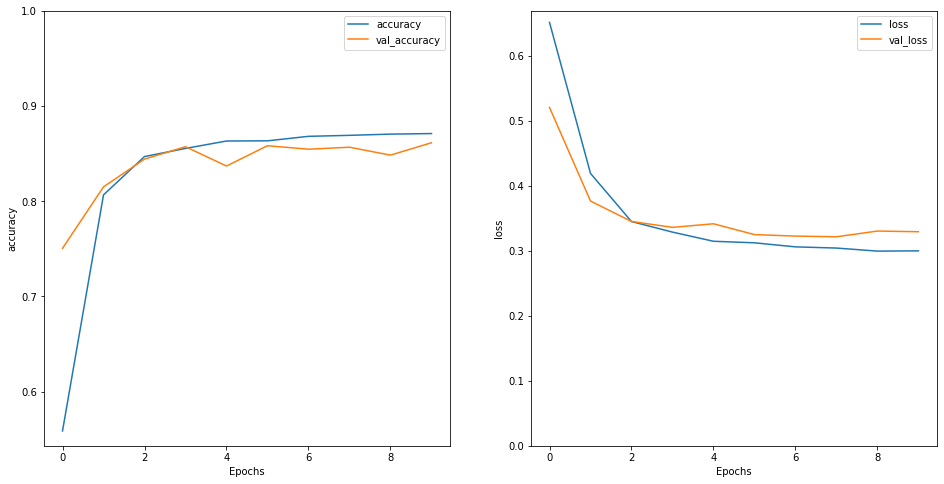

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.62843364]], dtype=float32)

# **Single GRU**

In [ ]:
model4 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder1.get_vocabulary()),output_dim=96,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(96)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model4.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adagrad(1e-4),metrics=['accuracy'])
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 96)          192000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 192)              111744    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                12352     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 316,161
Trainable params: 316,161
Non-tr

In [ ]:
history = model4.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 119s 278ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4917
Epoch 2/10
391/391 [==============================] - 102s 259ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4917
Epoch 3/10
391/391 [==============================] - 102s 259ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4917
Epoch 4/10
391/391 [==============================] - 101s 256ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4917
Epoch 5/10
391/391 [==============================] - 101s 257ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4917
Epoch 6/10
391/391 [==============================] - 102s 259ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4917
Epoch 7/10
391/391 [==============================] - 102s 257ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 -

In [ ]:
test_loss4, test_acc4 = model4.evaluate(test_dataset)
print('Test Loss:', test_loss4)
print('Test Accuracy:', test_acc4)

391/391 [==============================] - 50s 128ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss: 0.6931267380714417
Test Accuracy: 0.5


[[-0.01147594]]


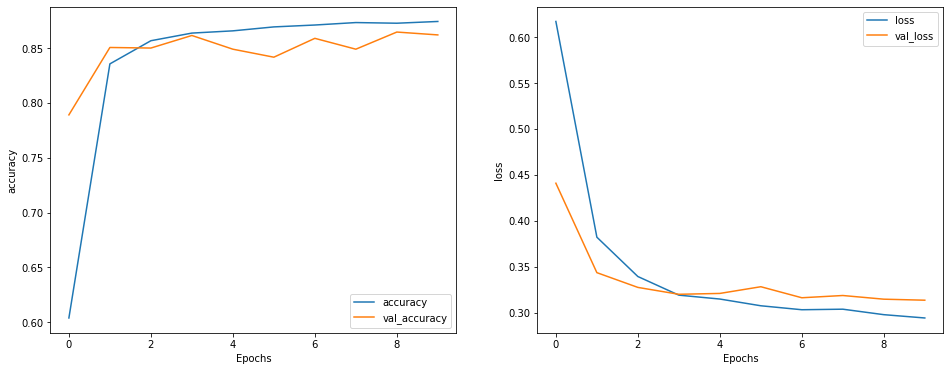

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model4.predict(np.array([sample_text]))
print(predictions)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Stacked Bidirectional LSTM**

In [ ]:
model1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 84, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(84,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 84)          84000     
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 168)        113568    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               51456     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
history = model1.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 208s 482ms/step - loss: 0.6169 - accuracy: 0.6039 - val_loss: 0.4409 - val_accuracy: 0.7891
Epoch 2/10
391/391 [==============================] - 180s 457ms/step - loss: 0.3821 - accuracy: 0.8356 - val_loss: 0.3436 - val_accuracy: 0.8505
Epoch 3/10
391/391 [==============================] - 179s 456ms/step - loss: 0.3394 - accuracy: 0.8567 - val_loss: 0.3275 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 180s 458ms/step - loss: 0.3191 - accuracy: 0.8636 - val_loss: 0.3200 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 180s 458ms/step - loss: 0.3148 - accuracy: 0.8657 - val_loss: 0.3210 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 181s 459ms/step - loss: 0.3075 - accuracy: 0.8693 - val_loss: 0.3282 - val_accuracy: 0.8417
Epoch 7/10
391/391 [==============================] - 181s 459ms/step - loss: 0.3032 - accuracy: 0.8710 - val_loss: 0.3162 -

In [ ]:
test_loss1, test_acc1 = model1.evaluate(test_dataset)

print('Test Loss:', test_loss1)
print('Test Accuracy:', test_acc1)

391/391 [==============================] - 73s 187ms/step - loss: 0.3134 - accuracy: 0.8604
Test Loss: 0.31340134143829346
Test Accuracy: 0.8604400157928467


[[-2.1442149]]


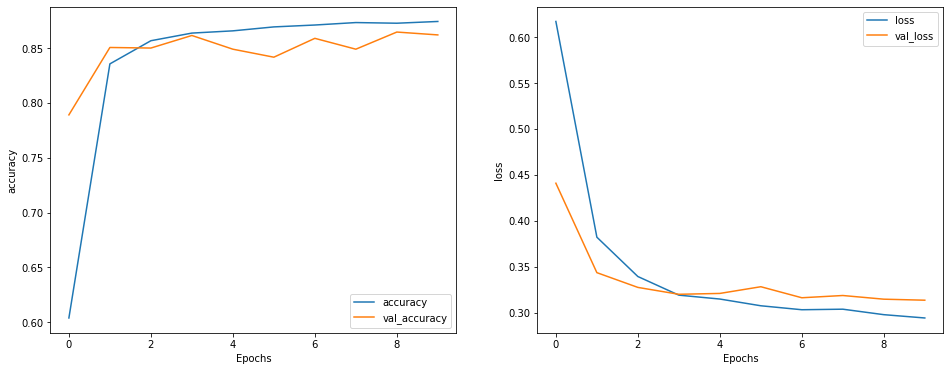

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model1.predict(np.array([sample_text]))
print(predictions)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# **Single Bi-LSTM with mean of Hidden Layers**

For Masters students: Can you modify the original example code such that instead of supplying the final state of the encoder to a fully connected layer, the mean of the hidden states at all time steps of the encoder is used for classification? You can look at https://www.tensorflow.org/api_docs/python/tf/keras/layers/Average (Links to an external site.) and https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional (Links to an external site.) 

In [ ]:
#input1 = tf.keras.layers.Input(shape=(16,))
#x1 = tf.keras.layers.Dense(8, activation='relu')(input1)
#input2 = tf.keras.layers.Input(shape=(32,))
#x2 = tf.keras.layers.Dense(8, activation='relu')(input2)
#avg = tf.keras.layers.Average()([x1, x2])
#out = tf.keras.layers.Dense(4)(avg)
#model = tf.keras.models.Model(inputs=[input1, input2], outputs=out)
#model3 =tf.keras.layers.Bidirectional(model2, merge_mode='concat', weights=None, backward_layer=None,**kwargs)
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), merge_mode='ave'),
    tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.RMSprop(1e-4),metrics=['accuracy'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 64)         66048     
 nal)                                                            
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                      

In [ ]:
history = model2.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 110s 252ms/step - loss: 0.6565 - accuracy: 0.5333 - val_loss: 0.5554 - val_accuracy: 0.7188
Epoch 2/10
391/391 [==============================] - 97s 245ms/step - loss: 0.4966 - accuracy: 0.7357 - val_loss: 0.4459 - val_accuracy: 0.8000
Epoch 3/10
391/391 [==============================] - 94s 239ms/step - loss: 0.4304 - accuracy: 0.7954 - val_loss: 0.4014 - val_accuracy: 0.8167
Epoch 4/10
391/391 [==============================] - 95s 240ms/step - loss: 0.3981 - accuracy: 0.8190 - val_loss: 0.4010 - val_accuracy: 0.8057
Epoch 5/10
391/391 [==============================] - 95s 240ms/step - loss: 0.3753 - accuracy: 0.8328 - val_loss: 0.3759 - val_accuracy: 0.8255
Epoch 6/10
391/391 [==============================] - 95s 241ms/step - loss: 0.3617 - accuracy: 0.8435 - val_loss: 0.3714 - val_accuracy: 0.8438
Epoch 7/10
391/391 [==============================] - 94s 238ms/step - loss: 0.3498 - accuracy: 0.8531 - val_loss: 0.3639 - val_a

In [ ]:
test_loss2, test_acc2 = model2.evaluate(test_dataset)
print('Test Loss:', test_loss2)
print('Test Accuracy:', test_acc2)

391/391 [==============================] - 50s 128ms/step - loss: 0.3225 - accuracy: 0.8644
Test Loss: 0.322494775056839
Test Accuracy: 0.8644000291824341


[[-0.9553572]]


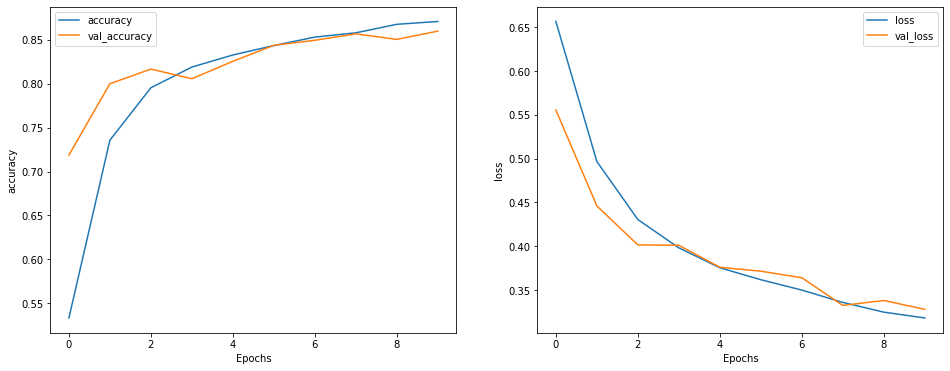

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model2.predict(np.array([sample_text]))
print(predictions)
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
import pandas as pd
df = pd.DataFrame({'Test Loss':[test_loss,test_loss4,test_loss1,test_loss2],'Test Accuracy':[test_acc,test_acc4,test_acc1,test_acc2]},index=['Single BiLSTM', 'Single GRU','Stacked BiLSTM','Single BiLSTM with mean of hidden layers'])
df

,Test Loss,Test Accuracy
Single BiLSTM,0.326095,0.86424
Single GRU,0.693127,0.50000
Stacked BiLSTM,0.313401,0.86044
Single BiLSTM with mean of hidden layers,0.322495,0.86440
